In [2]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## General Question
What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

## Specific Research Question
Can player experience level, age, played hours, and session activity patterns predict subscription status in the gaming platform dataset?
This question will allow us to:
-Identify which player characteristics are most strongly associated with newsletter subscription
-Understand how different player segments (by experience level) differ in subscription behavior
-Build a predictive model to classify potential subscribers


In [3]:
# Load the datasets
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

# Wrangle the players data; Convert variables to appropriate types
players <- players |>
  mutate(experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"), ordered = TRUE),
    gender = factor(gender),
    subscribe = factor(subscribe),
    played_hours = as.numeric(played_hours),
    Age = as.numeric(Age))

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# Clean sessions for analysis, since the time is in milliseconds divide by 1000 and multiply by 60 for minutes
sessions <- sessions |>
  mutate(duration = (as.numeric(original_end_time) - as.numeric(original_start_time)) / (1000 * 60))

In [5]:
players_vars <- tibble(
  Variable = names(players),
  Description = c(
    "experience" = "Player skill level (Factor: Beginner to Pro)",
    "subscribe" = "Subscription status (boolean: TRUE/FALSE)",
    "hashedEmail" = "Anonymized unique ID (character)",
    "played_hours" = "Total hours played (numeric)",
    "name" = "Player name (character)",
    "gender" = "Self-reported gender (factor)",
    "Age" = "Age in years (numeric)"
  )
)
players_vars

Variable,Description
<chr>,<chr>
experience,Player skill level (Factor: Beginner to Pro)
subscribe,Subscription status (boolean: TRUE/FALSE)
hashedEmail,Anonymized unique ID (character)
played_hours,Total hours played (numeric)
name,Player name (character)
gender,Self-reported gender (factor)
Age,Age in years (numeric)


In [6]:
sessions_vars <- tibble(
  Variable = names(sessions),
  Description = c(
    "hashedEmail" = "Anonymized ID linking to players (character)",
    "start_time" = "Session start timestamp DD/MM/YYYY HH:MM (character)",
    "end_time" = "Session end timestamp DD/MM/YYYY HH:MM (character)",
    "original_start_time" = "Unix timestamp in milliseconds (numeric)",
    "original_end_time" = "Unix timestamp in milliseconds (numeric)",
    "duration" = "Calculated session duration in minutes (numeric)"
  )
)
sessions_vars

Variable,Description
<chr>,<chr>
hashedEmail,Anonymized ID linking to players (character)
start_time,Session start timestamp DD/MM/YYYY HH:MM (character)
end_time,Session end timestamp DD/MM/YYYY HH:MM (character)
original_start_time,Unix timestamp in milliseconds (numeric)
original_end_time,Unix timestamp in milliseconds (numeric)
duration,Calculated session duration in minutes (numeric)


In [7]:
n_obs_players <- nrow(players)
n_vars_players <- ncol(players)
n_players <- nrow(players)

n_obs_sessions <- nrow(sessions)
n_vars_sessions <- ncol(sessions)
n_sessions <- nrow(sessions)

n_obs_players
n_vars_players
n_players

n_obs_sessions
n_vars_sessions
n_sessions

[1] 196

[1] 7

[1] 196

[1] 1535

[1] 6

[1] 1535

Dataset Overview

## players.csv

Number of observations: 197 players
Number of variables: 7 variables

## sessions.csv

Number of observations: 1,535 gaming sessions
Number of variables: 5 variables
Time period: May 4, 2024 to September 9, 2024 (128 days)
Unique players with sessions: 183 players

In [8]:
session_metrics <- sessions |>
  group_by(hashedEmail) |>
  summarize(
    session_count = n(),
    total_session_time = sum(duration, na.rm = TRUE),
    avg_session_duration = mean(duration, na.rm = TRUE)
  )
session_metrics

hashedEmail,session_count,total_session_time,avg_session_duration
<chr>,<int>,<dbl>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2,166.6667,83.33333
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1,0.0000,0.00000
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1,0.0000,0.00000
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,13,666.6667,51.28205
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,2,166.6667,83.33333
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,1,0.0000,0.00000
119f01b9877fc5ea0073d05602a353b91c4b48e4cf02f42bb8d661b46a34b760,1,0.0000,0.00000
18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3,41,1000.0000,24.39024
1a2b92f18f36b0b59b41d648d10a9b8b20a2adff550ddbcb8cec2f47d4d881d0,1,0.0000,0.00000


In [9]:
means_tbl <- players |>
  summarise(
    mean_played_hours = round(mean(played_hours, na.rm = TRUE), 2),
    mean_age = round(mean(Age, na.rm = TRUE), 2)
  )
means_tbl

mean_played_hours,mean_age
<dbl>,<dbl>
5.85,21.14


In [10]:
sumplay <- summary(players)
sumplay

    experience subscribe   hashedEmail         played_hours    
 Beginner:35   FALSE: 52   Length:196         Min.   :  0.000  
 Amateur :63   TRUE :144   Class :character   1st Qu.:  0.000  
 Regular :36               Mode  :character   Median :  0.100  
 Veteran :48                                  Mean   :  5.846  
 Pro     :14                                  3rd Qu.:  0.600  
                                              Max.   :223.100  
                                                               
     name                         gender         Age       
 Length:196         Agender          :  2   Min.   : 9.00  
 Class :character   Female           : 37   1st Qu.:17.00  
 Mode  :character   Male             :124   Median :19.00  
                    Non-binary       : 15   Mean   :21.14  
                    Other            :  1   3rd Qu.:22.75  
                    Prefer not to say: 11   Max.   :58.00  
                    Two-Spirited     :  6   NA's   :2      

In [11]:
sumsess <- summary(sessions)
sumsess

 hashedEmail         start_time          end_time         original_start_time
 Length:1535        Length:1535        Length:1535        Min.   :1.712e+12  
 Class :character   Class :character   Class :character   1st Qu.:1.716e+12  
 Mode  :character   Mode  :character   Mode  :character   Median :1.719e+12  
                                                          Mean   :1.719e+12  
                                                          3rd Qu.:1.722e+12  
                                                          Max.   :1.727e+12  
                                                                             
 original_end_time      duration     
 Min.   :1.712e+12   Min.   :  0.00  
 1st Qu.:1.716e+12   1st Qu.:  0.00  
 Median :1.719e+12   Median :  0.00  
 Mean   :1.719e+12   Mean   : 48.49  
 3rd Qu.:1.722e+12   3rd Qu.:166.67  
 Max.   :1.727e+12   Max.   :333.33  
 NA's   :2           NA's   :2       

In [12]:
summary(players$played_hours)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.100   5.846   0.600 223.100 

In [13]:
summary(players$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   9.00   17.00   19.00   21.14   22.75   58.00       2 

In [14]:
summary(players$experience)

Beginner  Amateur  Regular  Veteran      Pro 
      35       63       36       48       14

In [15]:
summary(players$subscribe)

FALSE  TRUE 
   52   144

In [16]:
summary(players$gender)

Agender            Female              Male        Non-binary 
                2                37               124                15 
            Other Prefer not to say      Two-Spirited 
                1                11                 6

In [17]:
outliers_hours <- sum(players$played_hours > 150, na.rm = TRUE)
zero_hours <- sum(players$played_hours == 0)
low_exp <- nrow(players |> filter(experience %in% c("Veteran", "Pro"), played_hours < 1))
youngest_age <- min(players$Age, na.rm = TRUE)
subscribe_rate <- round(mean(players$subscribe == TRUE)*100, 1)
pro_count <- sum(players$experience == "Pro")
oldest_age <- max(players$Age, na.rm = TRUE)
median_age <- median(players$Age, na.rm = TRUE)

outliers_hours
zero_hours
low_exp
youngest_age
median_age 
oldest_age
subscribe_rate
pro_count 

[1] 3

[1] 85

[1] 50

[1] 9

[1] 19

[1] 58

[1] 73.5

[1] 14

BIG ISSUES

Gender Data: a some names and genders seem to be incorrectly assigned, like the name of Flora, Natalie, and Luna are entered as male, which indicates that the gender variable might not be trustworthy to analyze.

There are extreme outliers in played hours.
three players exceed 150 hours and 75% of players exceed 0.80 hours or less; this trend may be due to data entry errors or bots and will need to be explicitly treated as outliers before modeling.

Missing Values: there are two rows (158 and 196) that are missing Age values and two rows (158 and 196) that are missing session end time values.

Experience Level vs Hours Inconsistency: The labels of experience do not match usage, as 40 Pro/Veteran players have played less than one hour; this mismatch indicates that experience might be self-reported or on a criterion not related to playtime, which in turn might compromise the predictive validity of experience as a predictor.

MODERATE ISSUES

Data Format Inconsistency: timestamps are inconsistently stored in Unix values in scientific notation.

POTENTIAL HIDDEN ISSUES

The possible hidden problems in the data are bias, because the lack of player registration timestamps makes it unclear whether the data is representative of the current states and may only capture highly engaged users. Also, time zone ambiguity can make interpretations more difficult since timestamps do not include explicit timezone information, overlapping sessions are not validated and may be used by individual players, and the short 128-day observation period may create sampling bias that makes it difficult to generalize.

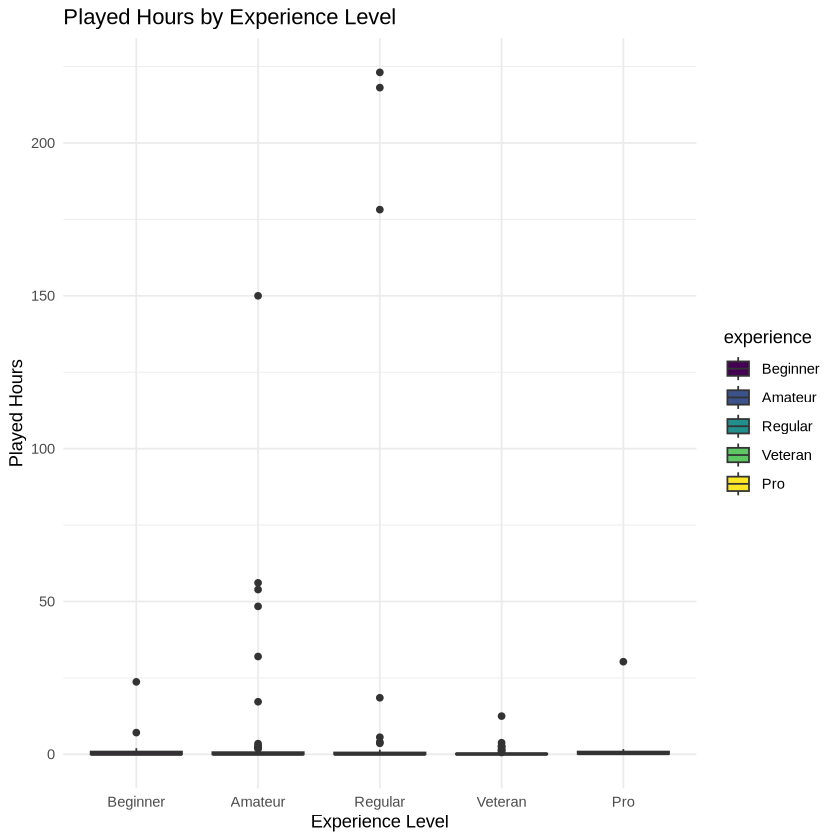

In [26]:
plot1 <- ggplot(players, aes(x = experience, y = played_hours, fill = experience)) +
  geom_boxplot() +
  labs(
    title = "Played Hours by Experience Level",
    x = "Experience Level",
    y = "Played Hours"
  ) +
  theme_minimal()
plot1


This plot shows that amateur players have higher on average play times. This will be useful in determining if this play time determines if average players are more likely to subscribe due to higher playtime. Some regular players have >150 hours so these may be outliers.

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


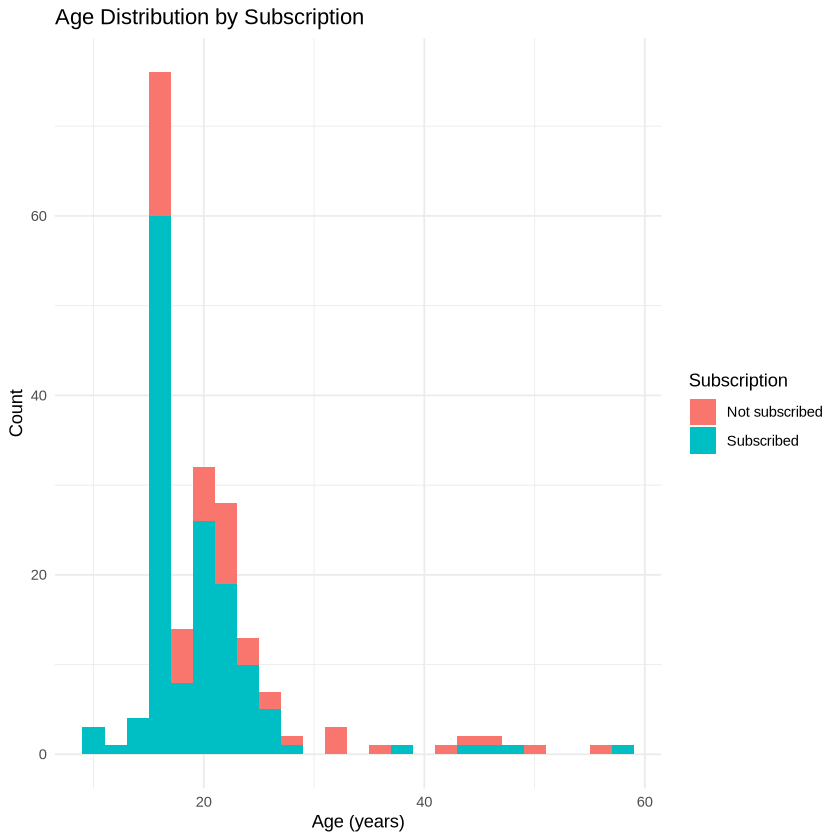

In [27]:
plot2 <- ggplot(players, aes(x = Age, fill = subscribe)) +
  geom_histogram(binwidth = 2) +
  labs(
    title = "Age Distribution by Subscription",
    x = "Age (years)",
    y = "Count",
    fill = "Subscription"
  ) +
  scale_fill_discrete(labels = c("Not subscribed", "Subscribed")) +
  theme_minimal()

plot2

Younger players < 30 years old have much higher subscription rates than older players. This will be useful in determining how age can work as a predictor for subscription status

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


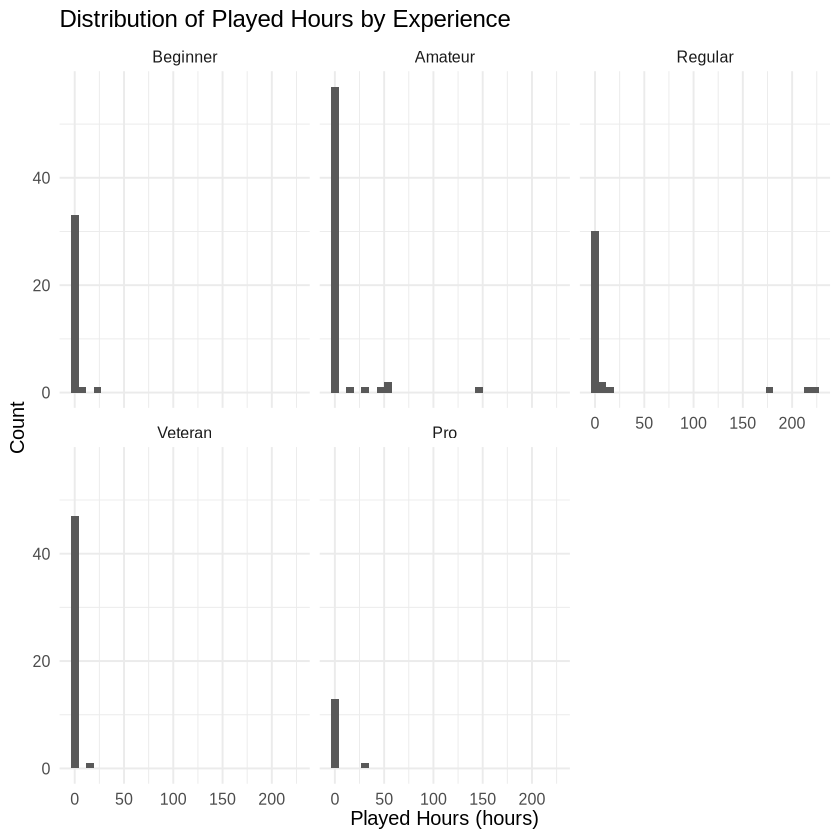

In [28]:
plot3 <- ggplot(players, aes(x = played_hours)) +
  geom_histogram() +
  facet_wrap(~ experience) +
  labs(
    title = "Distribution of Played Hours by Experience",
    x = "Played Hours (hours)",
    y = "Count"
  ) +
  theme_minimal(base_size = 12)
plot3

This plot doesnt give enough information to make an insight about played hours vs experience. The maority of players have less than one hour played but amateur and regular players have a larger spread.

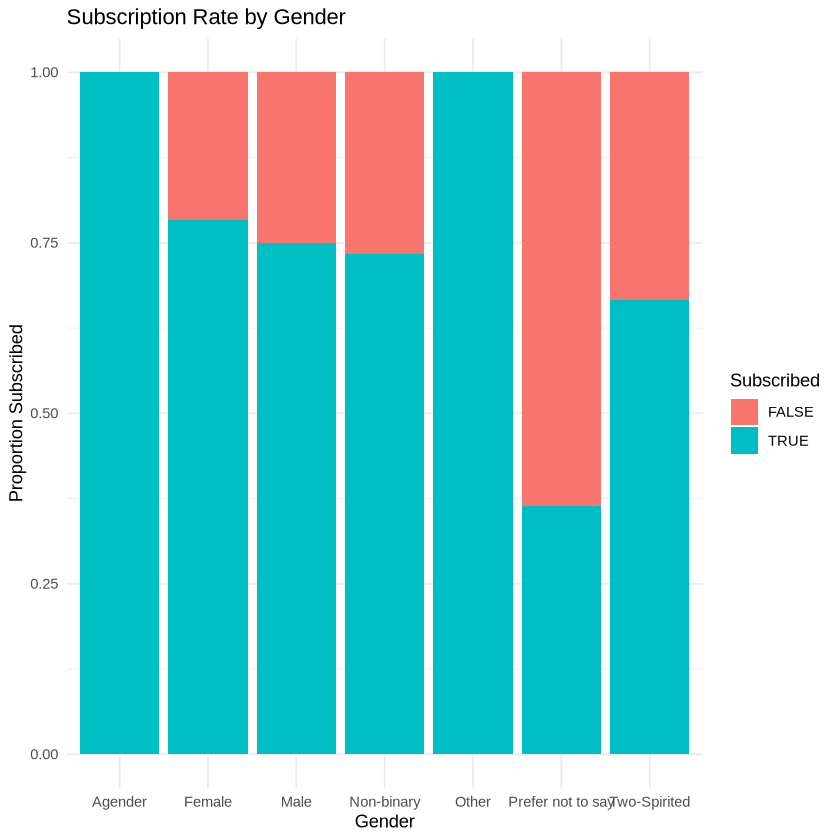

In [29]:
plot4 <- ggplot(players, aes(x = gender, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(title = "Subscription Rate by Gender",
       x = "Gender", y = "Proportion Subscribed",
       fill = "Subscribed") +
  theme_minimal()
plot4

This plot shows that males and females have an equal chance of subscribing. Since the other categories have very small sample sizes, they would not be viable since they introduce bias and sampling error. Based on this plot, gender does not seem like a strong predictor

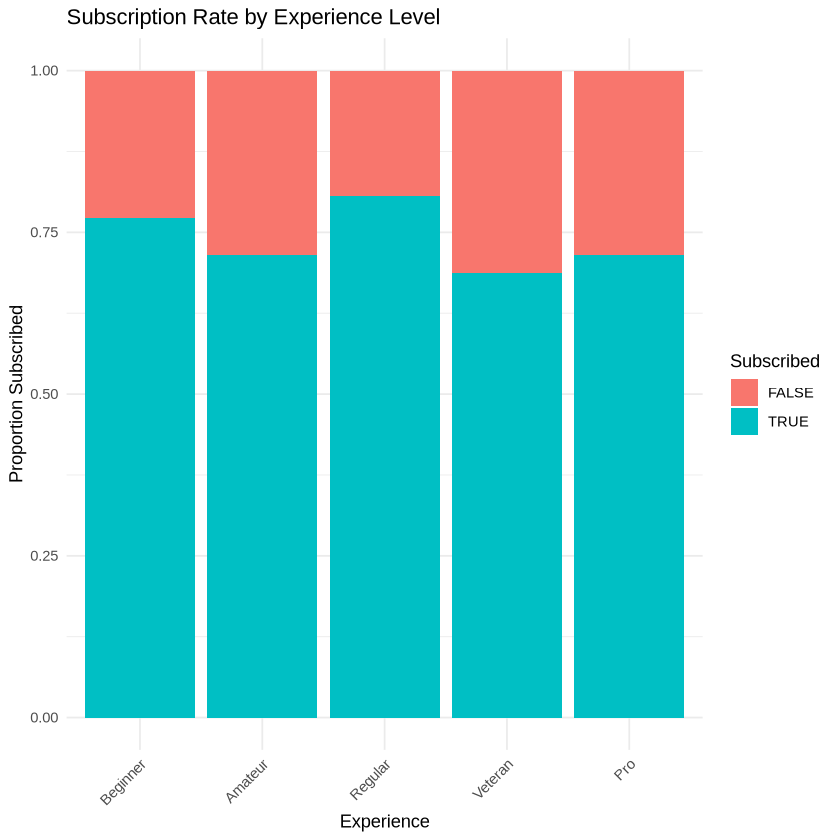

In [31]:
plot5 <- ggplot(players, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(title = "Subscription Rate by Experience Level",
       x = "Experience", y = "Proportion Subscribed",
       fill = "Subscribed") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
plot5

This plot shows that experience level is a weak predictor of subscription status as the distibutions are very similar with only slight deviations.

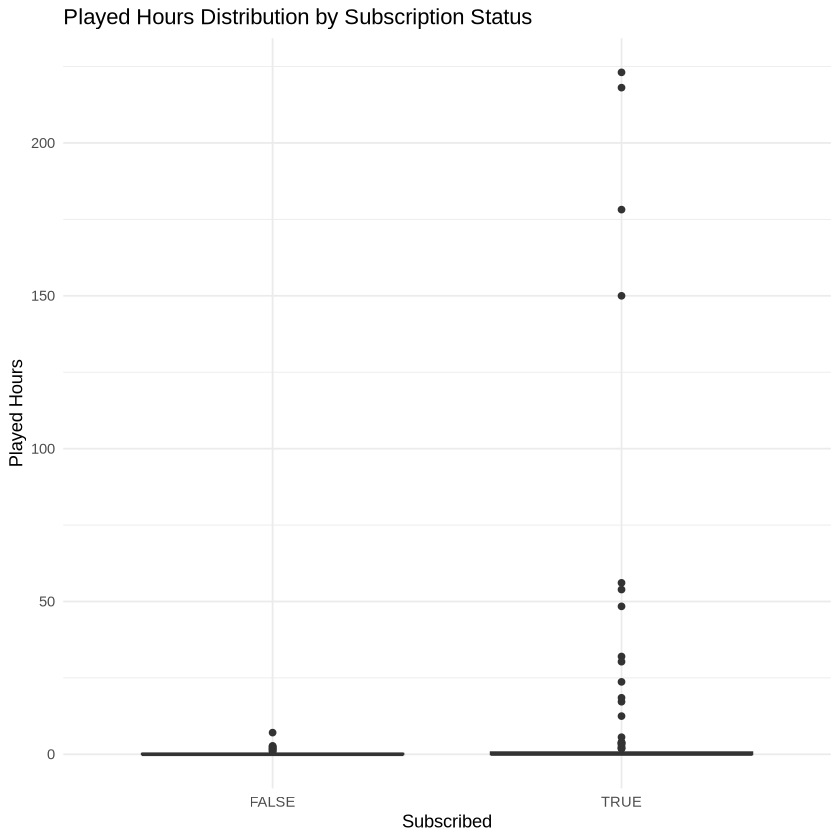

In [33]:
plot6 <- ggplot(players, aes(x = subscribe, y = played_hours)) +
  geom_boxplot() +
  labs(title = "Played Hours Distribution by Subscription Status",
       x = "Subscribed", y = "Played Hours") +
  theme_minimal()
plot6

This plot shows played hours vs subscription status. Based on this plot, it is evidence that players with more played hours have a higher rate of being subscribed, which means that players who have higher hours will be more likely to subscribe. This is a strong predictor of subscription status

In [34]:
session_metrics <- sessions |>
  group_by(hashedEmail) |>
  summarize(
    session_count = n(),
    total_session_time = sum(duration, na.rm = TRUE),
    avg_session_duration = mean(duration, na.rm = TRUE)
  )
session_metrics

hashedEmail,session_count,total_session_time,avg_session_duration
<chr>,<int>,<dbl>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2,166.6667,83.33333
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1,0.0000,0.00000
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1,0.0000,0.00000
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,13,666.6667,51.28205
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,2,166.6667,83.33333
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,1,0.0000,0.00000
119f01b9877fc5ea0073d05602a353b91c4b48e4cf02f42bb8d661b46a34b760,1,0.0000,0.00000
18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3,41,1000.0000,24.39024
1a2b92f18f36b0b59b41d648d10a9b8b20a2adff550ddbcb8cec2f47d4d881d0,1,0.0000,0.00000


In [35]:
players_full <- players |>
  left_join(session_metrics, by = "hashedEmail") 
players_full

experience,subscribe,hashedEmail,played_hours,name,gender,Age,session_count,total_session_time,avg_session_duration
<ord>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<int>,<dbl>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27,2000.0000,74.07407
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3,166.6667,55.55556
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1,0.0000,0.00000
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,1,0.0000,0.00000
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,1,0.0000,0.00000
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA,NA
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19,NA,NA,NA
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,1,0.0000,0.00000
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47,1,0.0000,0.00000


Warning message:
“Removed 71 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


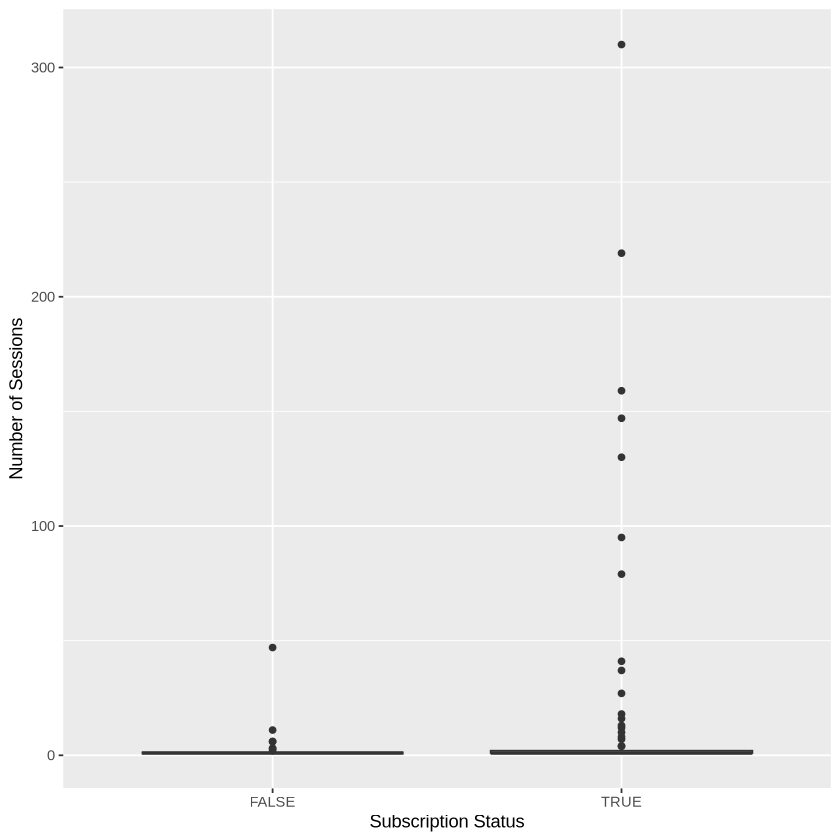

In [36]:
plot8 <- ggplot(players_full, aes(x = subscribe, y = session_count)) +
  geom_boxplot() +
  labs(x = "Subscription Status", y = "Number of Sessions")
plot8

This plot shows that players with more sessions (more logins over >50) are more likely to subscribe to the newsletter. Data are clustered at 0-25 hours for buth but the variance of true subscription status is higher with players who play more having been subscribed

Warning message:
“Removed 71 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


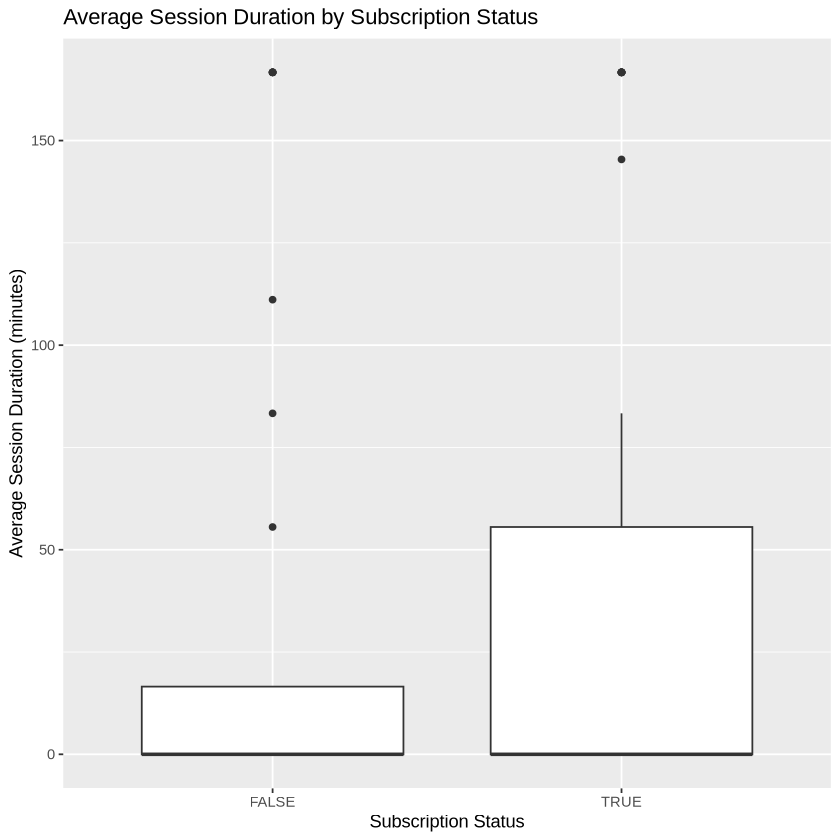

In [37]:
plot9 <- ggplot(players_full, aes(x = subscribe, y = avg_session_duration)) +
  geom_boxplot() +
  labs(
    title = "Average Session Duration by Subscription Status",
    x = "Subscription Status",
    y = "Average Session Duration (minutes)"
  )
plot9

This plot shows that users with a subscription tend to spend more time per session than users without a subscription since subscribers (TRUE) have much higher and more variable average session duration.

I propose using a k-nearest neighbors (kNN) classifier to predict the binary subscribe outcome based on player characteristics and behaviors, the Average Session Duration, Session Count, and Played Hours seem like strong predictors for subscription status based on our visualizations. This method is appropriate because it is flexible and non-parametric since it doesn't assume a linear relationship or shape. It operates in a way that "similar players behave similarly," which allows it to naturally capture the complex, non-linear interactions we expect in player data (e.g., played_hours might affect "Pros" and "Amateurs" differently based on the different interests/skills).

However, k-NN assumes that players who are similar in their characteristics will also be similar in their subscription behavior. Because it is distance-based, it also assumes that all features are on a comparable scale. Without scaling, a wide-range variable such as played_hours would dominate a narrow-range variable such as Age (9–30). Thus, we must standardize or normalize numerical features before training.

kNN's primary limitations are that it its performance can degrade as we add more features. Second, it is highly sensitive to irrelevant features and the feature scaling just mentioned. Most importantly, kNN is not directly interpretable; it does not produce a simple list of "most predictive features," making the main part of our question difficult to answer without significant follow-up analysis as we wont know how "predictive" each are, but we can run tests on it.

We will select the best kNN model by tuning its main hyperparameter, 'k' (the number of neighbors). This will be done using k-fold cross-validation (e.g., 5-fold) on the training set. After preprocessing, we will perform a single split of the data into a training set (70-80%) and a test set (20-30%). All model tuning via cross-validation will occur only on the training set and the test set will will not be used until the very end to provide a final evaluation of the model's performance.